In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import renom as rm
from renom.optimizer import Sgd
from renom.cuda.cuda import set_cuda_active
set_cuda_active(False)

boston = load_boston()
columns = boston.feature_names
X = boston.data.astype(np.float32)
y = boston.target.astype(np.float32)

X = (X - X.min()) / (X.max() - X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
print("X_train:{} y_train:{} X_test:{} y_test:{}".format(\
       X_train.shape, y_train.shape, X_test.shape, y_test.shape))

sequential = rm.Sequential([
    rm.Dense(30),
    rm.Dense(1)
])

batch_size = 32
epoch = 1000
optimizer = Sgd(lr=0.01)
N = len(X_train)

learning_curve = []
test_learning_curve = []
for i in range(epoch):
    perm = np.random.permutation(N)
    train_loss = 0
    test_loss = 0
    for j in range(N // batch_size):
        train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
        response_batch = y_train[perm[j*batch_size : (j+1)*batch_size]]
        with sequential.train():
            z = sequential(train_batch)
            l = rm.mean_squared_error(z, response_batch)
        grad = l.grad()
        grad.update(optimizer)
        train_loss += l.as_ndarray()
    train_loss = train_loss / (N // batch_size)

    z = sequential(X_test)
    l = rm.mean_squared_error(z, y_test)
    test_loss = l.as_ndarray()

    learning_curve.append(train_loss)
    test_learning_curve.append(test_loss)

    if i%100==0:
        print("epoch %03d train_loss%f test_loss:%f"%(i, train_loss, test_loss))

X_train:(404, 13) y_train:(404, 1) X_test:(102, 13) y_test:(102, 1)
epoch 000 train_loss125.888435 test_loss:38.687229
epoch 100 train_loss32.551207 test_loss:19.471546
epoch 200 train_loss31.342628 test_loss:19.060104
epoch 300 train_loss29.190000 test_loss:16.840561
epoch 400 train_loss26.098668 test_loss:19.102907
epoch 500 train_loss28.337122 test_loss:17.485762
epoch 600 train_loss26.345094 test_loss:13.029627
epoch 700 train_loss24.911205 test_loss:41.992607
epoch 800 train_loss20.635425 test_loss:11.626945
epoch 900 train_loss22.928068 test_loss:12.660599


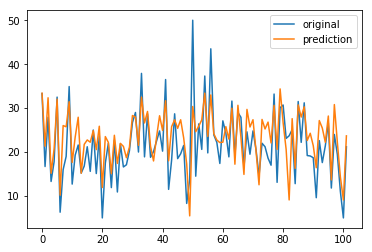

In [2]:
prediction = sequential(X_test)
plt.plot(y_test, label="original")
plt.plot(prediction, label="prediction")
plt.legend()
plt.show()

In [3]:
for i in range(X.shape[1]):
    print("{:8s}:{:10f}".format(columns[i],np.corrcoef(X[:,i], y)[0][1]))

CRIM    : -0.385832
ZN      :  0.360445
INDUS   : -0.483725
CHAS    :  0.175260
NOX     : -0.427321
RM      :  0.695360
AGE     : -0.376955
DIS     :  0.249929
RAD     : -0.381626
TAX     : -0.468536
PTRATIO : -0.507787
B       :  0.333461
LSTAT   : -0.737663


In [4]:
print("r2 score:{}".format(r2_score(y_test, prediction)))

r2 score:0.5509356758955286
